In [131]:
from cloudmesh.common.Shell import Shell
from cloudmesh.common.util import readfile
import sys
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import glob
from pprint import pprint
from cloudmesh.common.dotdict import dotdict
import numpy as np

In [132]:
list_of_dirs = [
    ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2', 2),
    ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30', 30),
    ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70', 70)]


In [133]:
files = []
for directory, epoch in list_of_dirs:
    gpulog = Path(directory) / "gpu0.log"
    eventlog = glob.glob(f"{directory}/*.err")[0]
    files.append(dotdict(
        {
            "epoch" : epoch,
            "eventlog": eventlog,
            "gpulog": gpulog
        })
    )

pprint (files)

[{'epoch': 2,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/dje5dj-45737981.err',
  'gpulog': PosixPath('data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log')},
 {'epoch': 30,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/dje5dj-45737982.err',
  'gpulog': PosixPath('data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log')},
 {'epoch': 70,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/dje5dj-45737983.err',
  'gpulog': PosixPath('data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log')}]


In [134]:
def convert_column_to_seconds(df, col):
    # df[[name]] = df[[name]].astype('datetime64[us]')
    df[col] = pd.to_datetime(df[col], errors='coerce')
    # df[[name]] = pd.to_datetime(df[[name]], errors='coerce')
    start_t = df[col].iloc[0]
    print (start_t, type(start_t))
    for index, row in df.iterrows():

        delta = df.loc[index, col] - start_t
        df.loc[index, col] = delta.total_seconds()
    # df[name_of_seconds_column] = df[name] - start_t
    # df[[name]] = df[[name]].astype(int)/1000000000
    return df

def fix_date_format(df, col):
    # if We have T in it, we do not need to fix
    for i, row in df.iterrows():
        value = df.loc[i,col]
        if "T" not in value:
            new_date = df.loc[i,col].replace(":", " ", 1)
            df.loc[i,col] = new_date
    df[col] = pd.to_datetime(df[col])
    return df

In [135]:
def read_energy(filename=None):
    location = Shell.map_filename(filename).path
    # 1: means removing hashes
    content = readfile(location).splitlines()[1:]
    # removing #
    content[0] = content[0][2:]
    # print(content[0:10])
    content = "\n".join(content)
    content = content.replace(', ', ',')
    df = pd.read_csv(io.StringIO(content),sep=',')

    df = fix_date_format(df, "time")
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    return df


In [136]:
def read_eventlog(filename):
    location = Shell.map_filename(filename).path
    content = readfile(location, encoding='utf-8')
    content = content.replace(', ', ',').splitlines()

    # headline = '# csv,timer,status,time,sum,start,tag,msg,uname.node,user,uname.system,platform.version'
    headline = Shell.cm_grep(content, '# csv,timer')[0]
    csv_lines = Shell.cm_grep(content, '# csv')
    csv_lines = Shell.cm_grep(csv_lines, 'Linux')
    csv_lines.insert(0, headline)
    # print("\n".join(csv_lines))
    content = "\n".join(csv_lines)
    df = pd.read_csv(io.StringIO(content),sep=',')
    df = df.rename(columns={'time':'dt'})
    df = df.rename(columns={'start':'time'})
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    df = df.drop(columns=['# csv', 'status', 'sum', 'uname.node', 'user', 'uname.system', 'platform.version', 'msg'])
    t = df.pop("time")
    df.insert(0, "time", t)
    return df

In [137]:
def export_figure(x='Time/s', y='Energy/W', filename=None):
   plt.xlabel(x)
   plt.ylabel(y)
   base = os.path.dirname(filename.replace('_', '-').lower())
   png = base + ".png"
   pdf = base + ".pdf"
   plt.savefig(png, bbox_inches='tight', dpi=600)
   plt.savefig(pdf, bbox_inches='tight')

In [138]:
def plot_energy(filename, epoch):
    df = read_energy(filename)
    label = f'Epoch {epoch}'
    df.rename(columns = {'0 power_draw W':label}, inplace=True)
    energy = df[['time', label]]
    # display(energy)
    ax = sns.lineplot(energy)

    poi = ['INIT',
       'data head setup',
       'RunTFTCustomVersion A',
       'RunTFTCustomVersion bestfit Epoch:0',
       'RunTFTCustomVersion bestfit finalize',
       'DLprediction Iteration',
       'DLResults_Graphs timer_num:0',
       'RunTFTCustomVersion bestfit finalize VisualizeTFT event_num:0']

    for i, row in df2.iterrows():
       label = row['timer']
       if label in poi:
          # print(row['timer'], row['start'])
          x = row['start']
          y = 180
          print(x, type(x), y, type(y), label, type(label))
          ax.text(x, y, label, rotation=45)
          ax.plot(x, y)

    # export_figure('Time', 'Energy', filename)
    return ax


In [141]:
list_of_filenames = [('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log', 30),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log', 70)]

for entry  in files:
    print (f"Generate output for Epoch {entry.epoch}")
    energylog = read_energy(entry.gpulog)
    eventlog = read_eventlog(entry.eventlog)

    t0_energy = energylog.time.iloc[0]
    t0_events = eventlog.time.iloc[0]

    t0 = min(t0_events, t0_energy)

    energylog["time"] = energylog["time"] - t0
    eventlog["time"] = eventlog["time"] - t0

    #eventlog["time"] = eventlog["time"] / np.timedelta64(1, 's')
    # energylog["time"] = energylog["time"] / np.timedelta64(1, 'us')

    display(energylog)
    display(eventlog)



Generate output for Epoch 2


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0 days 00:00:00,0,0,0,0,0,30,64.53
1,0 days 00:00:02.381160,0,0,0,0,0,30,64.53
2,0 days 00:00:04.747577,0,0,0,0,0,30,64.53
3,0 days 00:00:07.106233,0,0,0,0,0,30,64.53
4,0 days 00:00:09.457596,0,0,0,0,0,30,64.46
...,...,...,...,...,...,...,...,...
4515,0 days 02:44:48.009324,0,0,0,0,0,32,71.79
4516,0 days 02:44:50.157161,0,0,0,0,0,32,71.79
4517,0 days 02:44:52.331272,0,0,0,0,0,32,71.45
4518,0 days 02:44:54.482647,0,0,0,0,0,32,71.79


,time,timer,dt,tag
0,0 days 05:00:10.435667,total,None,TIMER1
1,0 days 05:00:10.435667,total,9876.208,TIMER2
2,0 days 05:00:25.435667,INIT,2.261,TIMER2
3,0 days 05:00:28.435667,EVAL,409.961,TIMER2
4,0 days 05:00:28.435667,PLOTS,385.099,TIMER2
...,...,...,...,...
224,0 days 07:44:43.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
225,0 days 07:44:43.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
226,0 days 07:44:44.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
227,0 days 07:44:44.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2


Generate output for Epoch 30


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0 days 00:00:00,0,0,0,0,0,28,62.86
1,0 days 00:00:02.172422,0,0,0,0,0,28,62.86
2,0 days 00:00:04.195892,0,0,0,0,0,28,62.86
3,0 days 00:00:06.382399,0,0,0,0,0,28,62.86
4,0 days 00:00:08.574598,0,0,0,0,0,28,62.86
...,...,...,...,...,...,...,...,...
12312,0 days 07:26:10.241591,0,0,0,0,0,30,70.40
12313,0 days 07:26:12.426120,0,0,0,0,0,30,70.40
12314,0 days 07:26:14.602164,0,0,0,0,0,30,70.68
12315,0 days 07:26:16.784935,0,0,0,0,0,30,70.68


,time,timer,dt,tag
0,0 days 05:00:10.461425,total,None,TIMER1
1,0 days 05:00:10.461425,total,26757.542,TIMER2
2,0 days 05:00:25.461425,INIT,2.095,TIMER2
3,0 days 05:00:28.461425,EVAL,413.412,TIMER2
4,0 days 05:00:28.461425,PLOTS,388.651,TIMER2
...,...,...,...,...
420,0 days 12:26:05.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
421,0 days 12:26:05.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
422,0 days 12:26:05.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
423,0 days 12:26:05.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2


Generate output for Epoch 70


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0 days 00:00:00,0,0,0,0,0,29,61.81
1,0 days 00:00:02.377373,0,0,0,0,0,29,61.81
2,0 days 00:00:04.745279,0,0,0,0,0,29,61.81
3,0 days 00:00:07.102939,0,0,0,0,0,29,61.81
4,0 days 00:00:09.455125,0,0,0,0,0,29,61.81
...,...,...,...,...,...,...,...,...
25104,0 days 14:00:56.757102,0,0,0,0,0,31,68.51
25105,0 days 14:00:58.411075,0,0,0,0,0,31,68.51
25106,0 days 14:01:00.048054,0,0,0,0,0,31,68.51
25107,0 days 14:01:01.685282,0,0,0,0,0,32,87.30


,time,timer,dt,tag
0,0 days 05:00:10.432375,total,None,TIMER1
1,0 days 05:00:10.432375,total,50441.073,TIMER2
2,0 days 05:00:25.432375,INIT,2.579,TIMER2
3,0 days 05:00:28.432375,EVAL,408.511,TIMER2
4,0 days 05:00:28.432375,PLOTS,383.499,TIMER2
...,...,...,...,...
700,0 days 19:00:48.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
701,0 days 19:00:48.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
702,0 days 19:00:49.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
703,0 days 19:00:49.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2


2022-12-21 17:55:48 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 180 <class 'int'> INIT <class 'str'>
2022-12-21 18:03:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 180 <class 'int'> data head setup <class 'str'>
2022-12-21 18:23:08 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
2022-12-21 20:35:54 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 180 <class 'int'> DLprediction Iteration <class 'str'>
2022-12-21 20:39:25 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 180 <class 'int'> DLResults_Graphs timer_num:0 <class 'str'>
2022-12-21 20:40:08 <class 'pandas._libs.tslibs.timestamps.Timestamp'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT event_num:0 <class 'str'>


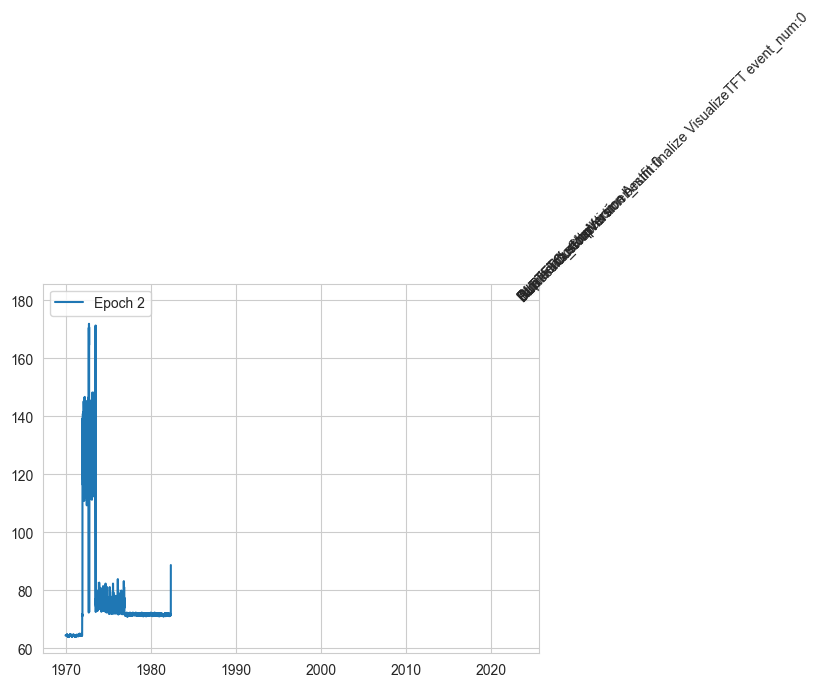

In [151]:
read_energy('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log')
ax = plot_energy('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2)
